# Implicit Diffusion

In [8]:
# Import libraries
%matplotlib inline
from __future__ import division
import scipy.linalg as sp 
from scipy.sparse.linalg import spsolve
import numpy as np
import matplotlib.pylab as plt
import timeit

In [2]:
# Time-step, size and other inputs
dt = 0.01
N = 100

# Advection speed
v = 0.2

# Time of calculation
t_end = 2.25

#Spatial coordinate discretisation
x = np.linspace(0,2,N)
dx = np.copy(x[1])

# Pamameter beta
beta = 1.0/4.0*v*dt/dx

In [5]:
## Gaussian profile
def gaussian(x):
    mu = 1.0
    sig2 = 0.1
    return 1.0/(np.sqrt(2.*np.pi*sig2))*np.exp(-np.power(x - mu, 2.)/(2.0*sig2))

## Box profile
def box_prof(x):
    u = np.ones_like(x)
    x_mask = np.where([(el > 0.5) and (el < 1) for el in x])
    u[x_mask] = 2.0
    return u

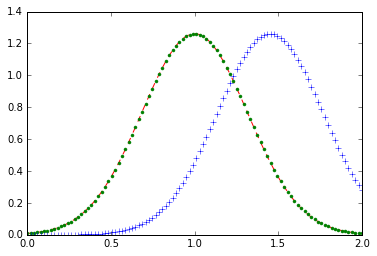

In [7]:
## Matrix initiation
matrix = np.eye(N-2, N-2) - np.eye(N-2,N-2,k=-1)*beta + np.eye(N-2,N-2,k=1)*beta

## Initial gaussian and box profile
u1 = gaussian(x)
u2 = box_prof(x)

## Right sides
def R_solutions(u,N):

    R = np.empty(N-2)
    R[0] = u[1]-beta*(u[2]-u[0])+beta*u[0]
    R[N-3] = u[N-2]-beta*(u[N-1]-u[N-3])-beta*u[N-1]

    R[1:N-3] = u[2:N-2]-beta*(u[3:N-1]-u[1:N-3])
   
    return R

## Running profile
def run(t_end,N):
    t = 0.0
    u = u1.copy()
    U = u2.copy()
    while time < t_end:
        ##rs = R_solutions(u,N)
        u[1:N-1] = spsolve(matrix,R_solutions(u,N))
        U[1:N-1] = spsolve(matrix,R_solutions(u,N))
        
        # Boundary condition
        u[N-1] = u[N-2] # Free outflow
        U[N-1] = u[N-2] # Free outflow
        u[0] = 0.       # Zero inflow
        U[0] = 0.       # Zero inflow

        t += dt
    return u,t


u_res,t = run(t_end,N)

# Srovnani numerickeho a exaktniho reseni
plt.plot(x,u1,'r--')
plt.plot(x,u_res,'g.')
plt.plot(x,gaussian(x-v*t_end),'b+')